In [210]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import detrend
from scipy.stats import gaussian_kde
%matplotlib inline

In [156]:
HOMEDIR = Path('/scistor/ivm/jsn295/')
sys.path.append(str(HOMEDIR))
from Weave.src.utils import agg_time
from SubSeas.helper_functions import monthtoseasonlookup

In [2]:
response = xr.open_dataarray(HOMEDIR / 'processed/t2m_europe.anom.nc')
clusterfield = xr.open_dataarray(HOMEDIR / 'clusters/t2m-q095.nc').sel(nclusters = 14)
reduced = response.groupby(clusterfield).mean('stacked_latitude_longitude')
reduced = reduced.sel(clustid = 9)

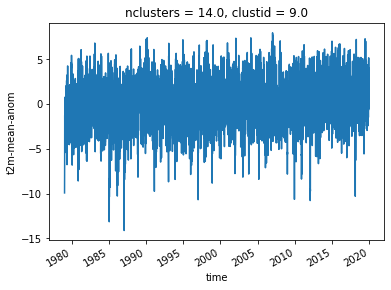

In [3]:
reduced.plot()

### Look at the sst patterns and z300 patterns

In [199]:
sstcorr = xr.open_dataarray(HOMEDIR / 'correlation_roll_spearman/sst_nhplus.5.corr.nc', decode_times = False)
z300corr = xr.open_dataarray(HOMEDIR / 'correlation_roll_spearman/z300_nhmin.5.corr.nc', decode_times = False)

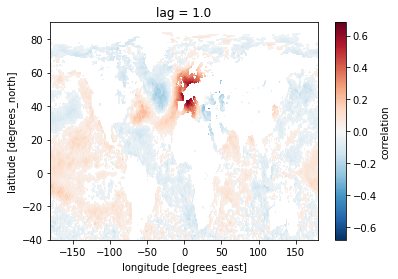

In [202]:
sstcorr[0].plot()

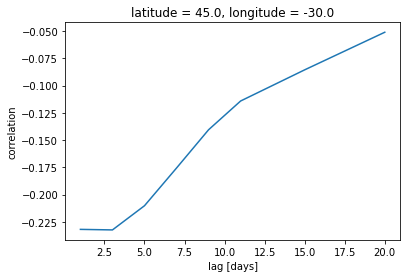

In [10]:
sstcorr.sel(latitude = 45, longitude = -30, method = 'nearest').plot()

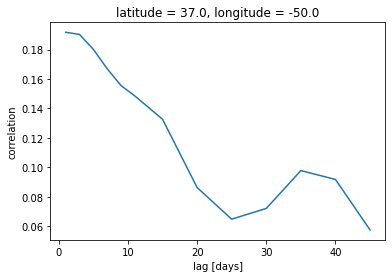

In [11]:
sstcorr.sel(latitude = 37, longitude = -50, method = 'nearest').plot()

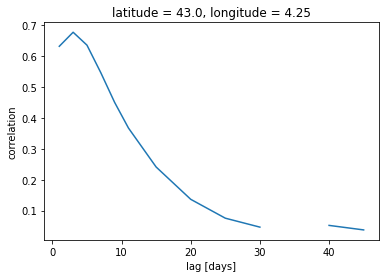

In [205]:
sstcorr.sel(latitude = 43, longitude = 4.3, method = 'nearest').plot()

In [206]:
sstcoords = pd.DataFrame({'latitude':[37,45,43],
                      'longitude':[-50,-30,4.3]},
                     index = pd.Index(['athot','atcold','medhot'], name = 'location'))

In [354]:
sstcoords

,latitude,longitude
location,,
athot,37,-50.0
atcold,45,-30.0
medhot,43,4.3


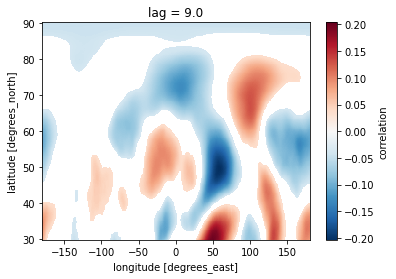

In [16]:
z300corr[4].plot()

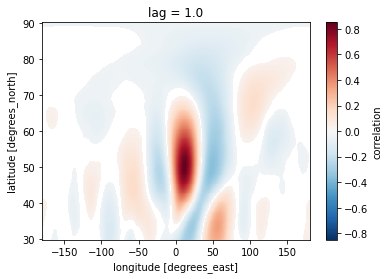

In [17]:
z300corr[0].plot()

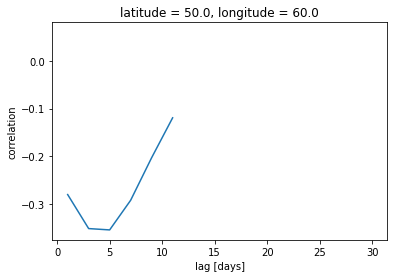

In [32]:
z300corr.sel(latitude = 50, longitude = 60, method = 'nearest').plot()

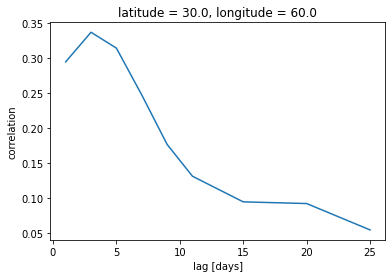

In [19]:
z300corr.sel(latitude = 30, longitude = 60, method = 'nearest').plot()

In [35]:
z300coords = pd.DataFrame({'latitude':[50,30],
                      'longitude':[60,60]},
                     index = pd.Index(['kzlow','irhigh'], name = 'location'))

In [36]:
z300coords

,latitude,longitude
location,,
kzlow,50,60
irhigh,30,60


In [207]:
coords = pd.concat([sstcoords, z300coords], axis = 0, keys = ['sst','z300'], names = ['variable','location'])

In [208]:
sstcorr.close()
z300corr.close()
coords

latitude  longitude
variable location                     
sst      athot           37      -50.0
         atcold          45      -30.0
         medhot          43        4.3
z300     kzlow           50       60.0
         irhigh          30       60.0

### Take these coords to extract unaggregated anomalie timeseries
And then investigate their (lagged / aggregated) properties and dependencies with the reduced response

In [209]:
data = {}
for ind, cords in coords.groupby(['variable','location']):
    array =  xr.open_dataarray((HOMEDIR / 'processed/sst_nhplus.anom.nc') if ind[0] == 'sst' else (HOMEDIR / 'processed/z300_nhmin.anom.nc'))
    #print(array.sel(latitude = cords['latitude'][0], longitude = cords['longitude'][0], method = 'nearest').values)
    data.update({ind:array.sel(latitude = cords['latitude'][0], longitude = cords['longitude'][0], method = 'nearest').values})
    data.update({('time',''):array.coords['time'].values})
    array.close()

In [228]:
test = pd.DataFrame(data)
test = test.set_index('time')
test.loc[:,('t2m','westeur')] = reduced.values

First check, concurrent and summer only

In [229]:
summer = test.loc[monthtoseasonlookup(test.index.month) == 'JJA',:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aac0fa1f128>,
      dtype=object)

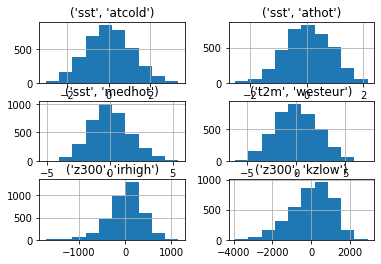

In [213]:
summer.hist()

So clearly the geopotential heigths are not really normally distributed within summer. Potentially due to a large trend?

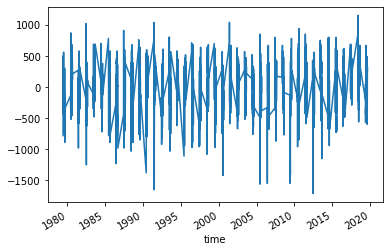

In [214]:
summer.loc[:,('z300','irhigh')].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aac0f8edda0>,
      dtype=object)

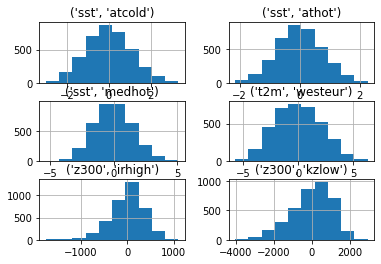

In [230]:
summer_det = summer.copy()
summer_det.loc[:,:] = detrend(summer_det, axis = 0)
summer_det.hist()

In [235]:
np.round(np.corrcoef(summer, rowvar = False), 3)

array([[ 1.   , -0.048, -0.29 ,  0.012,  0.105, -0.213],
       [-0.048,  1.   ,  0.299,  0.116, -0.101,  0.234],
       [-0.29 ,  0.299,  1.   ,  0.203, -0.109,  0.578],
       [ 0.012,  0.116,  0.203,  1.   , -0.207,  0.209],
       [ 0.105, -0.101, -0.109, -0.207,  1.   , -0.111],
       [-0.213,  0.234,  0.578,  0.209, -0.111,  1.   ]])

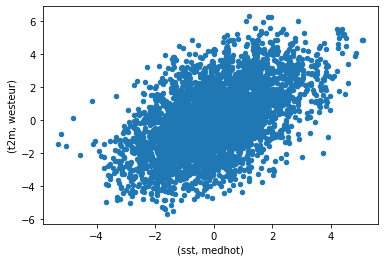

In [287]:
summer_det.plot.scatter(x = -4, y = -1)

### Now we go back to the full timeseries to make a lagging + aggregating + dependence

In [315]:
temp = test.copy()
tempxr = xr.DataArray(temp)

In [316]:
aggregated = agg_time(tempxr, ndayagg = 5, rolling = True)
agg = aggregated[aggregated.time.dt.season == 'JJA',:].to_pandas()

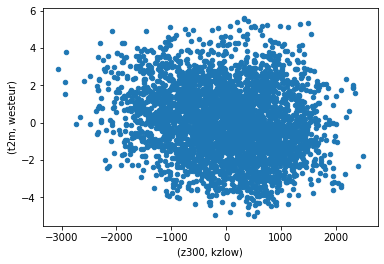

In [294]:
agg.plot.scatter(x = -2, y = -1)

In [295]:
np.round(np.corrcoef(agg,rowvar = False), 4)

array([[ 1.    , -0.0538, -0.2947,  0.0121,  0.1378, -0.2264],
       [-0.0538,  1.    ,  0.3132,  0.1433, -0.1325,  0.2652],
       [-0.2947,  0.3132,  1.    ,  0.2361, -0.1443,  0.6377],
       [ 0.0121,  0.1433,  0.2361,  1.    , -0.3148,  0.2752],
       [ 0.1378, -0.1325, -0.1443, -0.3148,  1.    , -0.1975],
       [-0.2264,  0.2652,  0.6377,  0.2752, -0.1975,  1.    ]])

In [312]:
bi_var = agg.loc[:,(slice(None),['kzlow','westeur'])]
bi_var_transp = bi_var.values.T
z = gaussian_kde(dataset=bi_var_transp)(bi_var_transp)
idx = z.argsort()

In [313]:
x = bi_var_transp[0,:][idx]
y = bi_var_transp[1,:][idx]
z = z[idx]

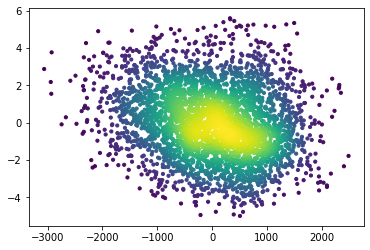

In [314]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10, edgecolor=None)
plt.show()

lag: 0 assigns 1979-01-01 to xvalue at 1979-01-01
lag: -1 assigns 1979-01-02 to xvalue at 1979-01-01
lag: -3 assigns 1979-01-04 to xvalue at 1979-01-01
lag: -5 assigns 1979-01-06 to xvalue at 1979-01-01
lag: -7 assigns 1979-01-08 to xvalue at 1979-01-01
lag: -10 assigns 1979-01-11 to xvalue at 1979-01-01


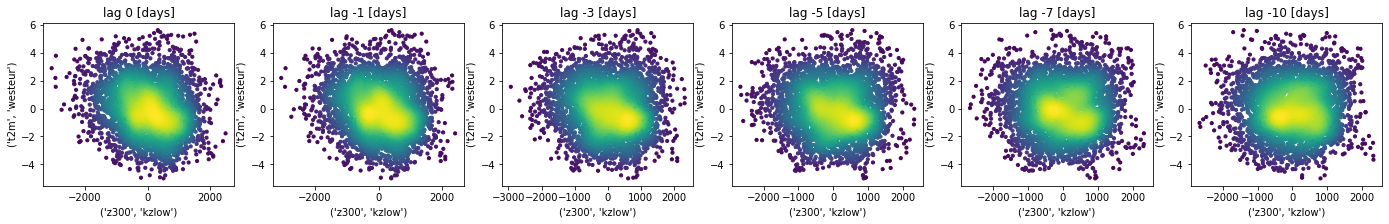

In [357]:
def density_plot(xy, ax, xlabel = None, ylabel = None, title = None):
    """
    shape (2,n_obs), with x on [0,:] and y on [1,:]
    """
    z = gaussian_kde(dataset=xy)(xy)
    idx = z.argsort()
    x = xy[0,:][idx]
    y = xy[1,:][idx]
    z = z[idx]
    ax.scatter(x, y, c=z, s=10, edgecolor=None)
    if not xlabel is None:
        ax.set_xlabel(xlabel)
    if not ylabel is None:
        ax.set_ylabel(ylabel)
    if not title is None:
        ax.set_title(title)
    return ax
    
aggregated = agg_time(tempxr, ndayagg = 5, rolling = True)
# Aggregation controls. For a single aggregation I want to make series of scatterplots at multiple lags. For one variable.
def lag_and_plot_pair(aggarr, laglist, x = ('z300','kzlow'), y = ('t2m','westeur')):
    """
    Is supplied with the aggregated array (outcome of agg_time), does lagging with xarray
    laglist is in days 
    Then subsetting and plotting the scatter    
    """
    aggarr = aggarr.copy()
    oritimeaxis = aggarr.coords['time']
    start = pd.Timestamp(oritimeaxis[0].values).strftime('%Y-%m-%d')
    yvals = aggarr.sel(dim_1 = y)[aggarr.time.dt.season == 'JJA']
    fig, axes = plt.subplots(ncols = len(laglist), figsize = (4*len(laglist),3))
    for lag in laglist:
        aggarr['time'] = oritimeaxis - pd.Timedelta(str(lag) + 'D')
        print(f'lag: {lag} assigns {pd.Timestamp(aggarr["time"][0].values).strftime("%Y-%m-%d")} to xvalue at {start}')
        xvals = aggarr.sel(dim_1 = x).reindex_like(yvals)
        xy = np.vstack([xvals.values, yvals.values])
        axes[laglist.index(lag)] = density_plot(xy, ax = axes[laglist.index(lag)], xlabel = x, ylabel = y, title = f'lag {lag} [days]')
        
    plt.show()

lag_and_plot_pair(aggregated, laglist = [0,-1,-3,-5,-7,-10])

lag: 0 assigns 1979-01-01 to xvalue at 1979-01-01
lag: -1 assigns 1979-01-02 to xvalue at 1979-01-01
lag: -3 assigns 1979-01-04 to xvalue at 1979-01-01
lag: -5 assigns 1979-01-06 to xvalue at 1979-01-01
lag: -7 assigns 1979-01-08 to xvalue at 1979-01-01
lag: -10 assigns 1979-01-11 to xvalue at 1979-01-01


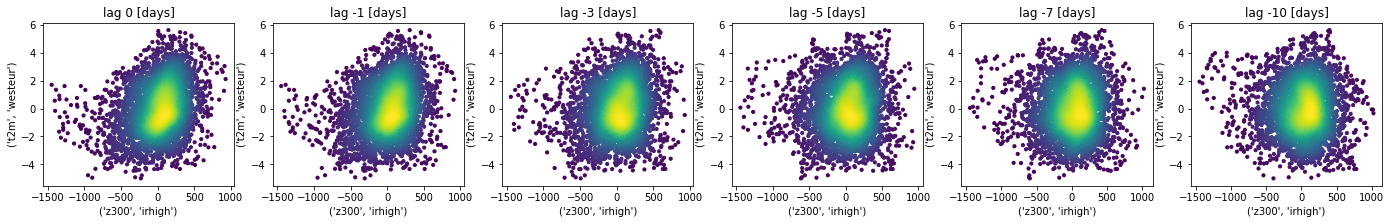

In [358]:
lag_and_plot_pair(aggregated, laglist = [0,-1,-3,-5,-7,-10], x=('z300','irhigh'))

lag: -1 assigns 1979-01-02 to xvalue at 1979-01-01
lag: -3 assigns 1979-01-04 to xvalue at 1979-01-01
lag: -5 assigns 1979-01-06 to xvalue at 1979-01-01
lag: -7 assigns 1979-01-08 to xvalue at 1979-01-01
lag: -10 assigns 1979-01-11 to xvalue at 1979-01-01
lag: -20 assigns 1979-01-21 to xvalue at 1979-01-01
lag: -30 assigns 1979-01-31 to xvalue at 1979-01-01


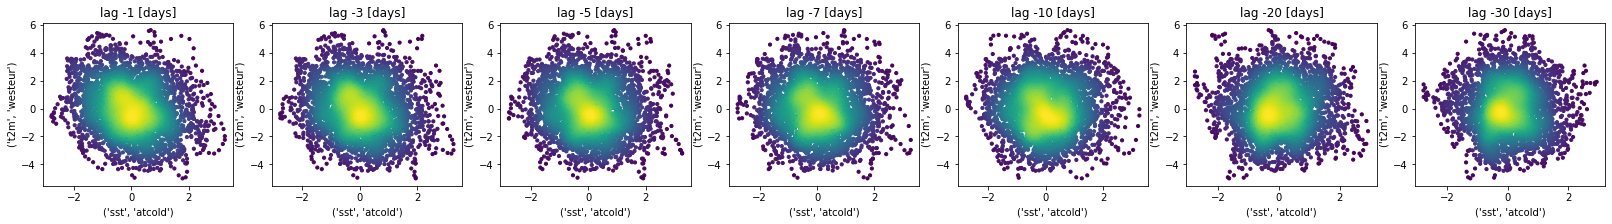

In [356]:
lag_and_plot_pair(aggregated, laglist = [-1,-3,-5,-7,-10,-20,-30], x=('sst','atcold'))

Interestingly you see the rolling aggregation in the fact that there are trajectories in the outliers. I wonder how the plots will change with different aggregation periods and with a detrending. Perhaps the dense yellow blob disappears. Detrending will have most influence if the trend is different in both (sign or absent/present)